In [ ]:
TOTAL_TIMESTEPS = 4000000
SCORE_MULTIPLIER = 1/10

In [1]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque

from torchvision import transforms as T

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)
        self.previous_coins = 0
        self.previous_score = 0

    def step(self, action):
        state, reward, done, info = self.env.step(action)

        # Check for score changes
        reward += (info['score'] - self.previous_score) * SCORE_MULTIPLIER

        # Update previous values
        self.previous_score = info['score']

        return state, reward, done, info

    def reset(self, **kwargs):
        self.previous_score = 0
        return self.env.reset(**kwargs)

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = CustomRewardWrapper(env)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [5]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [7]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0000025, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [8]:
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback)

Logging to ./logs/PPO_4
----------------------------
| time/              |     |
|    fps             | 220 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 146           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00038635987 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.000276      |
|    learning_rate        | 2.5e-06       |
|    loss                 | 122           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000672     |
|    value_loss           | 364           |
-------------------------

To view the log data, use this command in the logs/PPO_ folder with conda activated:  
`tensorboard --logdir=.`

In [12]:
# Load model
model = PPO.load('./train/best_model_4000000')

In [13]:
def record_video(env, model, out_directory, fps=30, max_frames = 100000):
  images = []
  done = False
  state = env.reset()
  frame_counter = 0
  while not done and frame_counter < max_frames:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    img = env.render('rgb_array')
    x = img.copy()
    images.append(x)
    frame_counter += 1
  imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)

In [15]:
record_video(env, model, './replay_ppo.mp4', 120)

By default, stable-baselines3 does not output the average reward over time during the training. We decided to run the checkpoints of the model three times and average the reward to generate a graph of the average reward with respect to the checkpoints (every 10000 frames).

In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = CustomRewardWrapper(env)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [ ]:
def get_avg_rewards(env, runs_per_model=3):
    rewards = []
    state = env.reset()

    for model_num in range(1, 401):
        print(f'loading model {model_num*10000}')
        model = PPO.load(f'./train/best_model_{model_num*10000}')
        total_reward = 0
        for i in range(runs_per_model):
            while True:
                action, _ = model.predict(state)
                state, reward, done, info = env.step(action)
                total_reward += reward
                if done:
                    break;
            print(f'finished run {i}')
        print(f'finished model {model_num*10000}\t avg reward: {total_reward/runs_per_model}')
        rewards.append(total_reward/runs_per_model)
    return rewards

In [7]:
avg_rewards = get_avg_rewards(env)

loading model 10000
finished run 0
finished run 1
finished run 2
finished model 10000	 avg reward: [139.]
loading model 20000
finished run 0
finished run 1
finished run 2
finished model 20000	 avg reward: [183.]
loading model 30000
finished run 0
finished run 1
finished run 2
finished model 30000	 avg reward: [220.33333]
loading model 40000
finished run 0
finished run 1
finished run 2
finished model 40000	 avg reward: [339.]
loading model 50000
finished run 0
finished run 1
finished run 2
finished model 50000	 avg reward: [249.66667]
loading model 60000
finished run 0
finished run 1
finished run 2
finished model 60000	 avg reward: [279.33334]
loading model 70000
finished run 0
finished run 1
finished run 2
finished model 70000	 avg reward: [141.66667]
loading model 80000
finished run 0
finished run 1
finished run 2
finished model 80000	 avg reward: [272.66666]
loading model 90000
finished run 0
finished run 1
finished run 2
finished model 90000	 avg reward: [220.33333]
loading model 10

***IMPORTANT***  
For some reason, matplotlib crashes the kernel for this specific combination of dependency versions. So, we had to save the output of the averages from the cell above into a file and manually recalculate the averages to generate a graph. BEFORE RUNNING THE CELL BELOW YOU MUST CHANGE YOUR KERNEL ENVIRONMENT TO THE LATEST DEPENDENCY VERSIONS OR ELSE THE KERNEL WILL CRASH

Text(0, 0.5, 'Avg Reward')

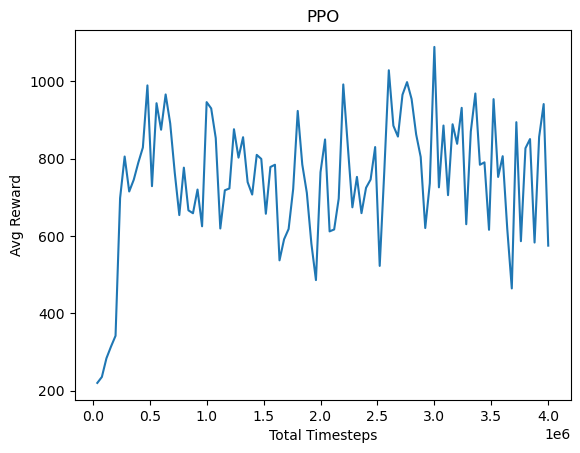

In [3]:
scores = []
with open('ppo_avg_10.txt') as f:
    for line in f:
        if 'avg reward: ' in line:
            i = line.find('avg')
            scores.append(float(line[i+13:-2]))

avg_rewards = np.average(np.array(scores).reshape(-1, 4), axis=1)

x = np.arange(1, len(avg_rewards)+1)
x *= 10000*4
plt.plot(x, avg_rewards)
plt.title("PPO")
plt.xlabel("Total Timesteps")
plt.ylabel("Avg Reward")